In [1]:
!pip3 install scikit-learn


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


## DBSCAN Algorithm Implementation

In [ ]:
# Add Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
import time
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN as SklearnDBSCAN
from sklearn.metrics import silhouette_score, adjusted_rand_score, davies_bouldin_score, calinski_harabasz_score, adjusted_mutual_info_score, mutual_info_score
from collections import deque
import importlib
import common.functions
importlib.reload(common.functions)

from common.functions import compute_gower_distance, visualize_clusters, compute_gower_distance_matrix


### Load datasets

In [115]:
dataset_path = "./../datasets"

iris_dataset_path = dataset_path + "/iris.csv"                                         
ai_global_index_path = dataset_path + "/AI_index_db.csv"
global_earthquake_data_path = dataset_path + "/earthquakes.csv"

In [122]:
iris_df = pd.read_csv(iris_dataset_path)
ai_global_index_df = pd.read_csv(ai_global_index_path)
global_earthquake_data_df = pd.read_csv(global_earthquake_data_path)

iris_df = iris_df.drop(columns=['species'])


ai_global_index_df = ai_global_index_df.drop(columns=['Country', 'Cluster'])

ai_global_index_categorical_cols = ['Income group', 'Political regime', 'Region']
ai_global_index_numerical_cols = [
    "Talent", 
    "Infrastructure", 
    "Operating Environment", 
    "Research", 
    "Development", 
    "Government Strategy", 
    "Commercial", 
    "Total score"
]

income_order = {'Lower middle': 0, 'Upper middle': 1, 'High': 2}
ai_global_index_df['Income group'] = ai_global_index_df['Income group'].map(income_order)
# ai_global_index_df = pd.get_dummies(ai_global_index_df, columns=ai_global_index_categorical_cols)

earthquake_drop_cols = [
    'id', 'title', 'date', 'time', 'updated', 'url', 'detailUrl', 
    'ids', 'sources', 'types', 'place', 'placeOnly', 'location', 
    'what3words', 'locationDetails'
]
global_earthquake_data_df = global_earthquake_data_df.drop(columns=earthquake_drop_cols)


earthquake_categorical_cols = [
    'type', 'alert', 'status', 'net', 'magType', 'geometryType',
    'continent', 'country', 'subnational', 'city', 'locality', 'postcode', 'timezone'
]
earthquake_numerical_cols = [
    "magnitude", "felt", "cdi", "mmi", "tsunami", "sig",
    "nst", "dmin", "rms", "gap", "depth", "latitude",
    "longitude", "distanceKM"
]
global_earthquake_data_df[earthquake_categorical_cols] = global_earthquake_data_df[earthquake_categorical_cols]
# global_earthquake_data_df = pd.get_dummies(global_earthquake_data_df, columns=earthquake_categorical_cols)

datasets = {
    "iris": iris_df,
    "ai_global_index": ai_global_index_df,
    "global_earthquake": global_earthquake_data_df
}

### DBSCAN Algorithm stated in report (see report/Part-I.pdf)

In [123]:
class CustomDBSCAN:
    """
    Custom DBSCAN implementation with support for a precomputed distance matrix.
    
    Parameters:
        eps (float): Maximum distance for two points to be considered neighbors.
        min_pts (int): Minimum number of points to form a dense region.
        metric (str): 'euclidean' (default) or 'precomputed'. If 'precomputed', X is assumed to be a distance matrix.
    """
    def __init__(self, eps=0.5, min_pts=5, metric='euclidean'):
        self.eps = eps
        self.min_pts = min_pts
        self.metric = metric
        self.labels_ = None

    def _region_query(self, X, point_idx):
        """
        Finds indices of all points within eps distance of the point at index point_idx.
        If metric=='precomputed', X is treated as a distance matrix.
        """
        if self.metric == 'precomputed':
            distances = X[point_idx, :]
        else:
            distances = np.linalg.norm(X - X[point_idx], axis=1)
        neighbors = np.where(distances <= self.eps)[0]
        return neighbors

    def _expand_cluster(self, X, point_idx, neighbors, cluster_id, labels):
        labels[point_idx] = cluster_id
        neighbors_queue = deque(neighbors)
        while neighbors_queue:
            neighbor_idx = neighbors_queue.popleft()
            if labels[neighbor_idx] == -2:
                labels[neighbor_idx] = -1
                neighbor_neighbors = self._region_query(X, neighbor_idx)
                if len(neighbor_neighbors) >= self.min_pts:
                    neighbors_queue.extend(neighbor_neighbors)
            if labels[neighbor_idx] == -1:
                labels[neighbor_idx] = cluster_id

    def fit(self, X):
        n = X.shape[0]
        labels = np.full(n, -2, dtype=int)  # -2: unvisited; -1: noise
        cluster_id = 0

        for i in range(n):
            if labels[i] != -2:
                continue
            labels[i] = -1
            neighbors = self._region_query(X, i)
            if len(neighbors) < self.min_pts:
                continue
            else:
                cluster_id += 1
                self._expand_cluster(X, i, neighbors, cluster_id, labels)
        self.labels_ = labels
        return self

    def fit_predict(self, X):
        self.fit(X)
        return self.labels_

### Comparing our custom implementation with that of Sci-kit Learn's

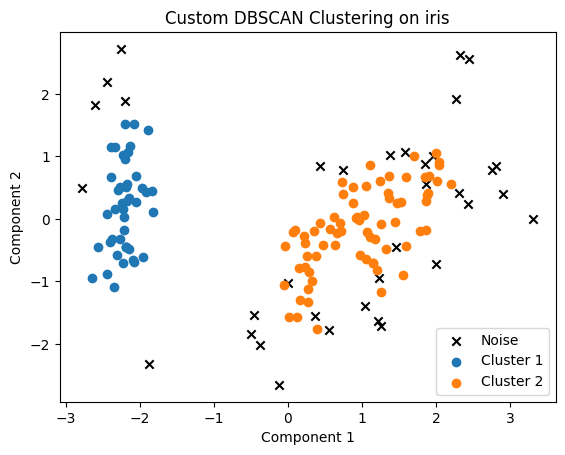

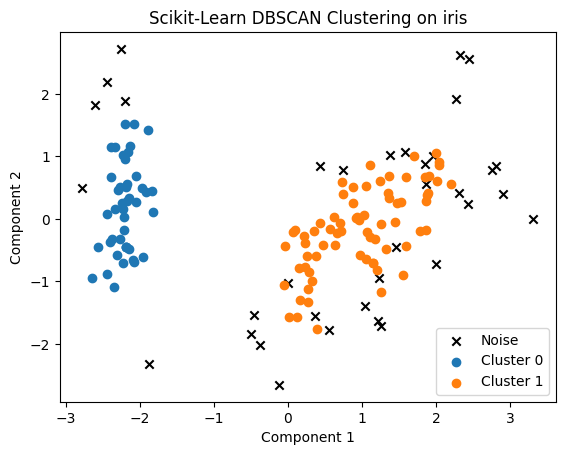

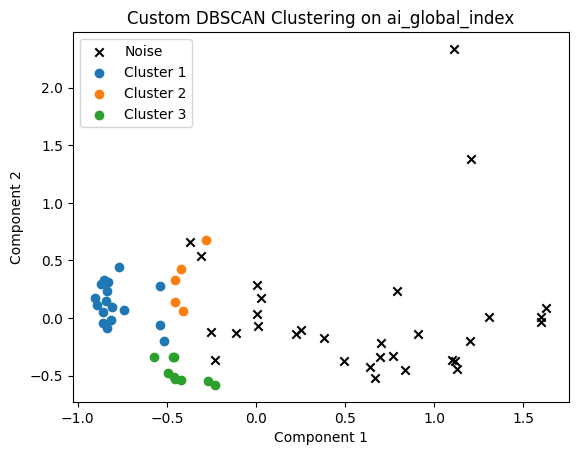

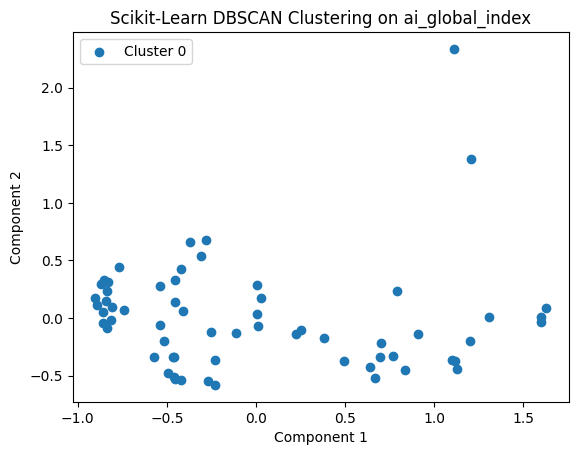

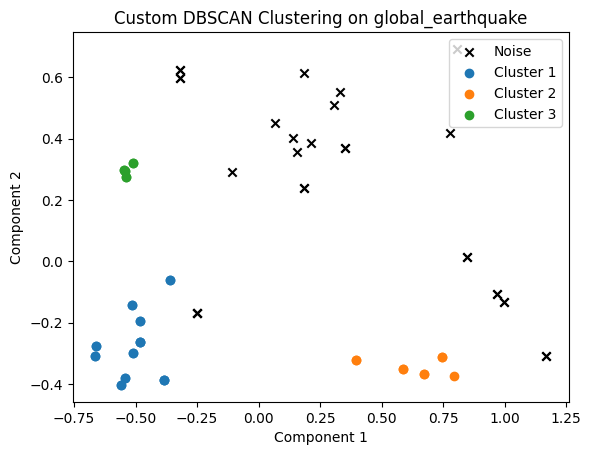

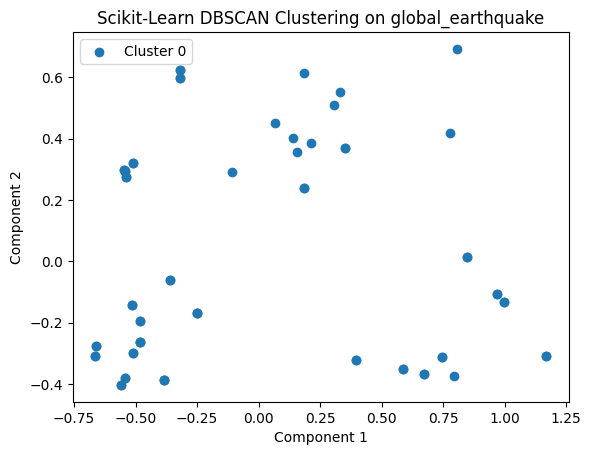

In [126]:
results = []

for name, df in datasets.items():
    metric = None
    # Preprocessing:
    # For the iris dataset, remove the species column (assumed to be the last column)
    if name == "iris":
        # Remove species label (assumed to be the last column), drop NaNs, and standardize.
        X = df.dropna().values
        X = StandardScaler().fit_transform(X)
        metric = 'euclidean'
    elif name == "ai_global_index":
        # For AI Global Index: use mixed data. Drop NaNs and compute Gower distance.
        df_clean = df.dropna()
        X = compute_gower_distance_matrix(df_clean, num_cols=ai_global_index_numerical_cols, cat_cols=ai_global_index_categorical_cols)
        metric = 'precomputed'
    elif name == "global_earthquake":
        # For Global Earthquake: use mixed data. Drop NaNs and compute Gower distance.
        df_clean = df.dropna()
        X = compute_gower_distance_matrix(df_clean, num_cols=earthquake_numerical_cols, cat_cols=earthquake_categorical_cols)
        metric = 'precomputed'
    else:
        # For Global Earthquake: select numeric columns, drop NaNs, and standardize.
        X = df.select_dtypes(include=[np.number]).dropna().values
        X = StandardScaler().fit_transform(X)
        metric = 'euclidean'


    # ---------------------------
    # Custom DBSCAN Implementation
    # ---------------------------
    custom_dbscan = CustomDBSCAN(eps=0.5, min_pts=5)
    start_time = time.time()
    labels_custom = custom_dbscan.fit_predict(X)
    custom_runtime = time.time() - start_time
    if metric == 'precomputed':
        custom_silhouette = silhouette_score(X, labels_custom, metric='precomputed') if len(set(labels_custom)) > 1 else None
    else:
        custom_silhouette = silhouette_score(X, labels_custom) if len(set(labels_custom)) > 1 else None
    results.append({
        "dataset": name,
        "type": "custom",
        "metric": metric,
        "silhouette": custom_silhouette,
        "runtime": custom_runtime,
        "cluster_count": len(set(labels_custom)) - (1 if -1 in labels_custom else 0),
        "noise_count": list(labels_custom).count(-1),
        # "labels": labels_custom.tolist()
    })
    visualize_clusters(X, labels_custom, f"Custom DBSCAN Clustering on {name}")

    # ---------------------------
    # Scikit-Learn DBSCAN Implementation
    # ---------------------------
    start_time = time.time()
    if metric == 'precomputed':
        sklearn_dbscan = SklearnDBSCAN(eps=0.5, min_samples=5, metric='precomputed')
    else:
        sklearn_dbscan = SklearnDBSCAN(eps=0.5, min_samples=5)
    labels_sklearn = sklearn_dbscan.fit_predict(X)
    sklearn_runtime = time.time() - start_time
    if metric == 'precomputed':
        sklearn_silhouette = silhouette_score(X, labels_sklearn, metric='precomputed') if len(set(labels_sklearn)) > 1 else None
    else:
        sklearn_silhouette = silhouette_score(X, labels_sklearn) if len(set(labels_sklearn)) > 1 else None
    results.append({
        "dataset": name,
        "type": "sklearn",
        "metric": metric,
        "silhouette": sklearn_silhouette,
        "runtime": sklearn_runtime,
        "cluster_count": len(set(labels_sklearn)) - (1 if -1 in labels_sklearn else 0),
        "noise_count": list(labels_sklearn).count(-1),
        # "labels": labels_sklearn.tolist()
    })
    visualize_clusters(X, labels_sklearn, f"Scikit-Learn DBSCAN Clustering on {name}")


results_df = pd.DataFrame(results)
results_df.to_csv("dbscan_results.csv", index=False)
